In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels as sm
from pathlib import Path
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# Initialize workflow parameters
data_path = Path('data/top_10_companies_by_sector.csv').resolve()
market_ticker = '^GSPC'
analysis_start = pd.Timestamp(2024, 1, 1, tz='America/Los_Angeles')
analysis_end = None



# Import data
data = pd.read_csv(data_path).sample(10, replace=False)
data

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap (B),Country,IPO Year,Volume,Sector,Industry
50,ISRG,Intuitive Surgical Inc. Common Stock,$591.65,-4.05,-0.68%,211.016093,United States,2000.0,837053,Health Care,Industrial Specialties
96,AVGO,Broadcom Inc. Common Stock,$235.04,0.00,0.00%,1101.716191,United States,2009.0,18461539,Technology,Semiconductors
110,CEG,Constellation Energy Corporation Common Stock,$313.58,-8.25,-2.563%,98.077350,United States,NaN,2642336,Utilities,Electric Utilities: Central
2,IPX,IperionX Limited American Depositary Share,$26.52,0.12,0.455%,0.682213,United States,NaN,50560,Basic Materials,Other Metals and Minerals
92,MSFT,Microsoft Corporation Common Stock,$411.44,-0.78,-0.189%,3058.637651,United States,1986.0,18122243,Technology,Computer Software: Prepackaged Software
78,MVST,Microvast Holdings Inc. Common Stock,$1.79,0.11,6.548%,0.579629,United States,2019.0,9350708,Miscellaneous,Industrial Machinery/Components
113,XEL,Xcel Energy Inc. Common Stock,$67.19,0.31,0.464%,38.583303,United States,NaN,2284291,Utilities,Power Generation
103,CHTR,Charter Communications Inc. Class A Common Sto...,$350.92,7.19,2.092%,49.811840,United States,NaN,612957,Telecommunications,Cable & Other Pay Television Services
44,NDAQ,Nasdaq Inc. Common Stock,$80.29,-0.92,-1.133%,46.147288,United States,NaN,2497954,Finance,Investment Bankers/Brokers/Service
82,SBAC,SBA Communications Corporation Class A Common ...,$209.24,2.93,1.42%,22.498032,United States,1999.0,526293,Real Estate,Real Estate Investment Trusts


In [3]:
def standardize(X):
    return (X - np.mean(X)) / np.std(X)

def pct_change(X):
    return np.diff(X) / X[:-1] * 100

In [4]:
ticker1 = standardize(pct_change(yf.download("AAPL", start="2024-01-01", end="2025-02-01")['Close'].to_numpy().flatten()))
ticker2 = standardize(pct_change(yf.download("FSLR", start="2024-01-01", end="2025-02-01")['Close'].to_numpy().flatten()))
ticker1


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


array([-0.58480121, -0.94354879, -0.34567114,  1.59439826, -0.22524429,
        0.32088188, -0.2912545 ,  0.05291421, -0.91718924, -0.4255424 ,
        2.17224767,  0.99961286,  0.76769091,  0.38845579, -0.30924576,
       -0.18624204, -0.68977305, -0.31625956, -1.39406402, -1.40176889,
        0.84870733, -0.44147187,  0.60824282,  0.52463166, -0.02946719,
       -0.46554656,  0.21231457, -0.68901915, -0.845442  , -0.40048758,
       -0.1778481 , -0.64968437, -0.35260835,  0.21864423,  0.70441272,
       -0.7600681 , -0.58229945,  0.48901694, -0.5254685 , -0.32363731,
       -0.48451419, -1.81634174, -2.02694763, -0.4740282 , -0.11830129,
        0.63508534,  0.7448648 ,  0.12177431, -0.90380673,  0.6826224 ,
       -0.22064814,  0.36913082,  0.86554384,  0.94291745, -2.88151697,
        0.29601145, -0.64074079, -0.52871056,  1.39052082, -0.79620095,
       -0.65144208, -0.55116228,  0.2607352 , -0.40618577,  0.24037985,
       -0.52808062,  0.42900342, -0.83613274,  2.90870059,  0.52

In [5]:
def remove_outliers(X, Y, threshold=3):
    """
    Remove outliers from paired arrays X and Y.
    If a value is an outlier in either X or Y, both corresponding values are removed.
    
    Args:
        X, Y: numpy arrays of same length
        threshold: number of standard deviations to consider a point an outlier
    
    Returns:
        X_clean, Y_clean: numpy arrays with outliers removed
    """
    # Convert to numpy arrays if not already
    X = np.array(X)
    Y = np.array(Y)
    
    # Calculate z-scores for both arrays
    z_scores_X = np.abs((X - np.mean(X)) / np.std(X))
    z_scores_Y = np.abs((Y - np.mean(Y)) / np.std(Y))
    
    # Create mask for values to keep (not outliers in either array)
    mask = (z_scores_X < threshold) & (z_scores_Y < threshold)
    
    # Return filtered arrays
    return X[mask], Y[mask]

# Example usage:
ticker1_clean, ticker2_clean = remove_outliers(ticker1, ticker2, threshold=3)
print(f"Original length: {len(ticker1)}")
print(f"After removing outliers: {len(ticker1_clean)}")

# Recalculate correlation with clean data
pearson_corr_clean = sp.stats.pearsonr(ticker1_clean, ticker2_clean)
print(f"\nCorrelation after removing outliers: {pearson_corr_clean.statistic:.3f}")
print(f"P-value after removing outliers: {pearson_corr_clean.pvalue:.3f}")

Original length: 271
After removing outliers: 264

Correlation after removing outliers: 0.093
P-value after removing outliers: 0.130


In [6]:
# Pearson
pearson_corr = sp.stats.pearsonr(ticker1, ticker2)
pearson_corr

PearsonRResult(statistic=0.15468777942442616, pvalue=0.01076985632920873)

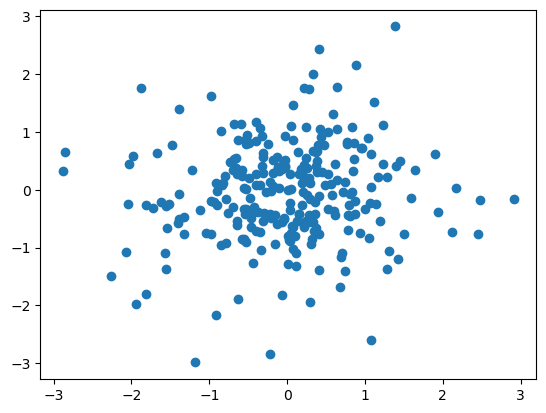

In [7]:
plt.scatter(ticker1_clean, ticker2_clean)

In [8]:
def rolling_beta(stock_returns, market_returns, window):
    """
    Compute rolling beta of a stock relative to the market.
    
    Parameters:
    - stock_returns: numpy array of stock returns
    - market_returns: numpy array of market returns
    - window: rolling window size (e.g., 30 for 30-day rolling beta)
    
    Returns:
    - numpy array of rolling beta values (NaN for the first (window-1) values)
    """
    betas = np.full(len(stock_returns), np.nan)  # Initialize with NaNs

    for i in range(window, len(stock_returns)):
        # Extract rolling window slices
        r_s = stock_returns[i-window:i]  # Stock returns for window
        r_m = market_returns[i-window:i]  # Market returns for window
        
        # Compute covariance and variance
        cov_matrix = np.cov(r_s, r_m)
        cov_stock_market = cov_matrix[0, 1]
        var_market = cov_matrix[1, 1]
        
        # Compute beta
        betas[i] = cov_stock_market / var_market if var_market != 0 else np.nan  # Avoid division by zero

    return betas


In [14]:
market_returns = standardize(pct_change(yf.download(market_ticker, start="2024-01-01", end="2025-02-01")['Close'].to_numpy().flatten()))
rolling_b1 = rolling_beta(ticker1, market_returns, 60)[60:]
rolling_b2 = rolling_beta(ticker2, market_returns, 60)[60:]
np.corrcoef(rolling_b1, rolling_b2)[0, 1]


[*********************100%***********************]  1 of 1 completed


0.6199468224573534

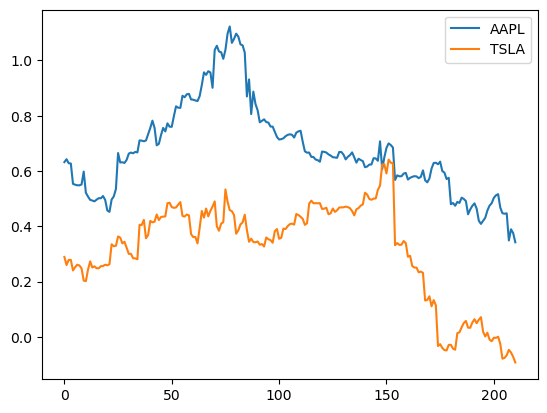

In [10]:
plt.plot(rolling_b1)
plt.plot(rolling_b2)
plt.legend(['AAPL', 'TSLA'])
plt.show()

In [13]:
def compute_r_squared(stock_returns_1, stock_returns_2):
    """
    Compute R^2 between two stocks based on their daily returns.
    
    Parameters:
    - stock_returns_1: numpy array of first stock's returns
    - stock_returns_2: numpy array of second stock's returns
    
    Returns:
    - R^2 value
    """
    # Compute Pearson correlation coefficient
    correlation_matrix = np.corrcoef(stock_returns_1, stock_returns_2)
    correlation = correlation_matrix[0, 1]  # Extract correlation value
    
    # Compute R^2
    r_squared = correlation ** 2
    return r_squared

r_squared = compute_r_squared(ticker1_clean, ticker2_clean)
r_squared

0.00873493016362239